<a href="https://colab.research.google.com/github/sm-lee-1/Caba_nlp/blob/main/DL20_classifying_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMDB 데이터셋

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 50,000개로 이루어진 IMDB 데이터셋을 사용하겠습니다. 이 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 나뉘어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.

왜 훈련 데이터와 테스트 데이터를 나눌까요? 같은 데이터에서 머신 러닝 모델을 훈련하고 테스트해서는 절대 안 되기 때문입니다! 모델이 훈련 데이터에서 잘 작동한다는 것이 처음 만난 데이터에서도 잘 동작한다는 것을 보장하지 않습니다. 중요한 것은 새로운 데이터에 대한 모델의 성능입니다(사실 훈련 데이터의 레이블은 이미 알고 있기 때문에 이를 예측하는 모델은 필요하지 않습니다). 예를 들어 모델이 훈련 샘플과 타깃 사이의 매핑을 모두 외워버릴 수 있습니다. 이런 모델은 처음 만나는 데이터에서 타깃을 예측하는 작업에는 쓸모가 없습니다. 다음 장에서 이에 대해 더 자세히 살펴보겠습니다.

MNIST 데이터셋처럼 IMDB 데이터셋도 케라스에 포함되어 있습니다. 이 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

In [2]:
from keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words=10000)
# 매개변수 num_words=10000 : 훈련 데이터에서 가장 자주 나타나는 단어 10000개만 사용한다는 의미임

17465344/17464789 [==============================] - 0s 0us/step


In [3]:
print(train_data.shape)
print(train_labels[0])

(25000,)
1


In [ ]:
# 변수 train_data와 test_data는 리뷰 목록이며 단어 인덱스의 리스트이다. 단어 시퀀스가 인코딩된 것이다.
# test_lables는 부정(0), 긍정(1)을 나타내는 리스트이다.

In [4]:
max([max(sequence) for sequence in train_data])

9999

In [5]:
train_data[:5]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [ ]:
# word_index 는 단어와 정수 인덱스를 매핑한 딕셔너리

데이터 준비  
신경망에 숫자 리스트를 주입할 수는 없다. 리스트를 텐서로 바꾸어주어야 한다.  
- 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한 다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫번째 층으로 사용
- 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환한다. 예를들어 [3,5]를 3과 5 위치는 1이고 나머지는 0인 10000 차원의 벡터로 변환 ==> 아래 코드

In [8]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i,sequence] = 1.   # results[i] 에서 특정 인덱스의 위치를 1로 만든다.
  return results 

x_train = vectorize_sequences(train_data)   
x_test = vectorize_sequences(test_data)

In [9]:
x_train.shape

(25000, 10000)

In [10]:
x_train[:5]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [11]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [12]:
y_train[:5]

array([1., 0., 0., 1., 0.], dtype=float32)

신경망 모델 만들기  
Dense 층을 쌓을 때 중요한 구조상의 결정 필요
- 얼마나 많은 층을 사용할 것인가?
- 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?


In [15]:
from keras import models
from keras import layers

# 'relu' : 최대값 , 'sigmoid' : 확률을 판단해서 0.5보다 작으면 0/크면 1
# 16 : 은닉 유닛 
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))  # 은닉층, 입력층
model.add(layers.Dense(16, activation='relu'))  # 은닉층, 입력층
model.add(layers.Dense(1, activation='sigmoid'))  # 출력층

컴파일
- 손실함수  
- 옵티마이저  
- 모니터링 방법


In [16]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [20]:
# 훈련 검증 : 10000개 샘플을 검증용 세트로 분리
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [21]:
# 512개씩 미니 배치로 만들어 20번의 에포크 동안 훈련

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2993 - accuracy: 0.9031 - val_loss: 0.2983 - val_accuracy: 0.8909
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.2173 - accuracy: 0.9285 - val_loss: 0.2754 - val_accuracy: 0.8905
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1708 - accuracy: 0.9427 - val_loss: 0.2739 - val_accuracy: 0.8910
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1377 - accuracy: 0.9569 - val_loss: 0.2820 - val_accuracy: 0.8888
Epoch 5/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1168 - accuracy: 0.9632 - val_loss: 0.2967 - val_accuracy: 0.8876
Epoch 6/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0949 - accuracy: 0.9723 - val_loss: 0.3170 - val_accuracy: 0.8846
Epoch 7/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0788 - accuracy: 0.9773 - val_loss: 0.3374 - val_accuracy: 0.8791
Epoch 8/20
30

In [24]:
history_dict = history.history

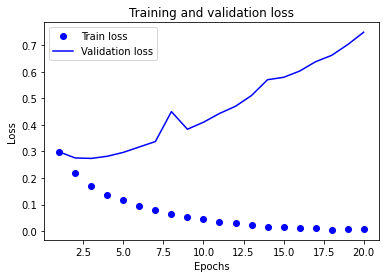

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

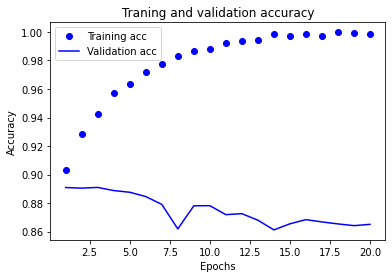

In [25]:
plt.clf() # 그래프 초기화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Traning and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
from keras import models
from keras import layers

# 'relu' : 최대값 , 'sigmoid' : 확률을 판단해서 0.5보다 작으면 0/크면 1
# 16 : 은닉 유닛 
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [28]:
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 11ms/step - loss: 0.5507 - accuracy: 0.7563
Epoch 2/4
49/49 [==============================] - 1s 11ms/step - loss: 0.2808 - accuracy: 0.9073
Epoch 3/4
49/49 [==============================] - 1s 12ms/step - loss: 0.1977 - accuracy: 0.9323
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3086 - accuracy: 0.8778


In [30]:
results

[0.3086440861225128, 0.8777599930763245]

In [31]:
model.predict(x_test)

array([[0.22639918],
       [0.99994814],
       [0.9693915 ],
       ...,
       [0.16043784],
       [0.13278289],
       [0.77065957]], dtype=float32)